In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [21]:

def create_data_model(waypoints):
    data = {}
    data['distance_matrix'] = compute_distance_matrix(waypoints)
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def compute_distance_matrix(waypoints):
    n = len(waypoints)
    distance_matrix = []
    for i in range(n):
        row = []
        for j in range(n):
            dx = waypoints[i][0] - waypoints[j][0]
            dy = waypoints[i][1] - waypoints[j][1]
            distance = int((dx**2 + dy**2)**0.5)
            row.append(distance)
        distance_matrix.append(row)
    return distance_matrix

def draw_circle(ax, center, radius):
    circle = plt.Circle(center, radius, color='b', fill=False)
    ax.add_artist(circle)
    
def print_solution(manager, routing, solution):
    print('TSP Distance: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    return plan_output



In [22]:
def angle_between_points(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
import numpy as np

def angle_between_points(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def point_on_circle(center, angle, radius):
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    return (x, y)

In [23]:
def plot_solution(waypoints, plan_output, radius):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))

    for i, point in enumerate(ordered_points[:-1]):
        plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        if i > 0 and i < len(ordered_points) - 2:  # Exclude start and end points from circles
            draw_circle(ax, point, radius)

    new_path = [ordered_points[0]]
    for i in range(1, len(ordered_points) - 2):
        # calculate angle and chords for the current waypoint
        angle = angle_between_points(ordered_points[i-1], ordered_points[i])
        nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
        chord_start = point_on_circle(ordered_points[i], angle - np.pi , radius)
        chord_end = point_on_circle(ordered_points[i], nextangle , radius)

        # calculate the chord for the previous waypoint
        prev_angle = angle_between_points(ordered_points[i - 2] if i > 1 else ordered_points[0], ordered_points[i-1])
        prev_chord_end = point_on_circle(ordered_points[i-1], prev_angle + np.pi / 2, radius)

        # add the point on the current waypoint's circle that is closest to the previous waypoint
        if np.linalg.norm(np.array(chord_start) - np.array(prev_chord_end)) < np.linalg.norm(np.array(chord_end) - np.array(prev_chord_end)):
            new_path.extend([chord_start, chord_end])
            ax.plot(*zip(*[chord_start, chord_end]), 'r-')  # visualize the chord
        else:
            new_path.extend([chord_end, chord_start])
            ax.plot(*zip(*[chord_end, chord_start]), 'r-')  # visualize the chord

    # add the ending point
    new_path.append(ordered_points[-1])
    total_distance = sum(np.linalg.norm(np.array(new_path[i]) - np.array(new_path[i+1])) for i in range(len(new_path) - 1))
    print(f"Total distance of new path: {total_distance:.2f}")
    ax.plot(*zip(*new_path), linestyle='-', marker='o')
    

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Solution')
    plt.grid()
    plt.axis('equal')
    plt.show()
    return total_distance

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_solution(waypoints, plan_output, radius):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    # ordered_points.append(ordered_points[0])

    fig, ax = plt.subplots(figsize=(10, 6))
    

    ax.scatter(*zip(*ordered_points),color='yellow',s=80)
    ax.scatter(ordered_points[0][0], ordered_points[0][1], color='red',s=120)
    ax.annotate('Home base', (ordered_points[0][0], ordered_points[0][1]),
            textcoords="offset points", xytext=(0,10), ha='center', va='bottom', color='white')

    for i, point in enumerate(ordered_points[:-1]):
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5), color='blue', fontsize=10, ha='center', va='center')
        if i > 0 and i < len(ordered_points) - 2:  # Exclude start and end points from circles
            draw_circle(ax, point, radius)

    new_path = [ordered_points[0]]
    for i in range(1, len(ordered_points) - 2):
        # calculate angle and chords for the current waypoint
        angle = angle_between_points(ordered_points[i-1], ordered_points[i])
        nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
        chord_start = point_on_circle(ordered_points[i], angle - np.pi , radius)
        chord_end = point_on_circle(ordered_points[i], nextangle , radius)

        # calculate the chord for the previous waypoint
        prev_angle = angle_between_points(ordered_points[i - 2] if i > 1 else ordered_points[0], ordered_points[i-1])
        prev_chord_end = point_on_circle(ordered_points[i-1], prev_angle + np.pi / 2, radius)

        # add the point on the current waypoint's circle that is closest to the previous waypoint
        if np.linalg.norm(np.array(chord_start) - np.array(prev_chord_end)) < np.linalg.norm(np.array(chord_end) - np.array(prev_chord_end)):
            new_path.extend([chord_start, chord_end])
            # ax.plot(*zip(*[chord_start, chord_end]), 'r-')  # visualize the chord
        else:
            new_path.extend([chord_end, chord_start])
            # ax.plot(*zip(*[chord_end, chord_start]), 'r-')  # visualize the chord

    # add the ending point
    new_path.append(ordered_points[-1])
    total_distance = sum(np.linalg.norm(np.array(new_path[i]) - np.array(new_path[i+1])) for i in range(len(new_path) - 1))
    print(f"Total distance of new path: {total_distance:.2f}")

    for i in range(len(new_path) - 1):
        x, y = new_path[i]
        dx = new_path[i+1][0] - x
        dy = new_path[i+1][1] - y
        ax.arrow(x, y, dx, dy, head_width=0.5, head_length=0.8, lw=1.5)
    ax.axis('off')
    ax.set_facecolor('none')
    fig.set_facecolor('none')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Interest Point', color='white')
    plt.axis('equal')
    plt.show()
    return total_distance

# Please ensure the remaining helper functions like draw_circle, angle_between_points, and point_on_circle are defined.


TSP Distance: 232 miles
Route for vehicle 0:
 0 -> 6 -> 4 -> 2 -> 1 -> 12 -> 8 -> 11 -> 3 -> 9 -> 10 -> 7 -> 5 -> 0

Total distance of new path: 218.74


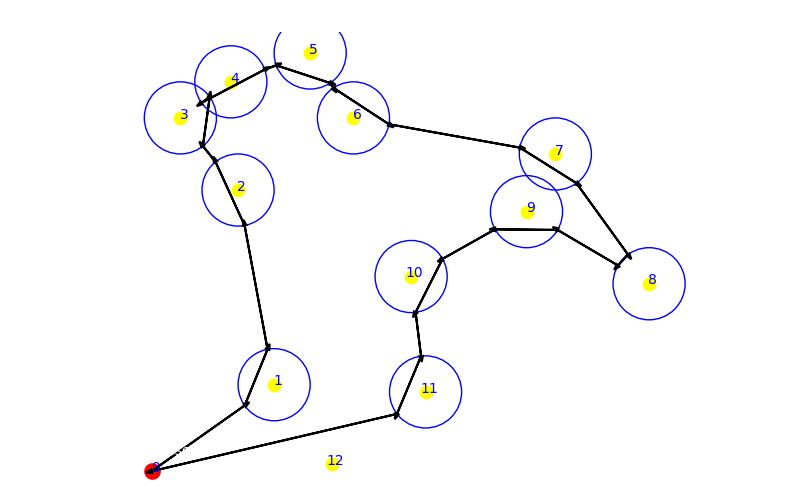

In [34]:
def main(waypoints):
    data = create_data_model(waypoints)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        plan_output = print_solution(manager, routing, solution)
        plot_solution(waypoints, plan_output, radius)
        return plan_output
    return None
if __name__ == '__main__':
    # waypoints = [(random.randint(0, 70), random.randint(0, 70)) for _ in range(12)]
    # waypoints.insert(0, (0, 0))
    waypoints = [(0,0),(10,10),(17,3),(20,12.5)] # 4
    waypoints = [(0,0),(10,10),(17,3),(20,12.5),(30,-2.5),(10,-5)] # 6 
    waypoints = [(0,0),(10,10),(17,3),(20,12.5),(30,-2.5),(10,-5),(30,14),(40,10)] # 8 
    waypoints = [(0,0),(10,10),(17,3),(20,12.5),(30,-2.5),(10,-5),(30,14),(40,10),(40,-10),(20,-10)]# 10 
    waypoints = [(0, 0),(11, 54),(4, 49),(69, 26),(12, 39),(25, 1),(17, 12),(38, 11),(28, 49),(52, 36),(36, 27),(56, 44),(22, 58)] #13
    radius = 5
    plan_output = main(waypoints)
    